# TODO Needs Comments


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import seaborn as sns
from sklearn import model_selection


mpl.rcParams['figure.dpi'] = 300


# Configuring paths and loading raw data
home_directory = r"D:\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation/"
table_location = home_directory + "tabular_data"

translation_frame = pd.read_csv("translation_dataframe_timepoints.csv")
name_mapping = {key:new_key for key,new_key in zip(translation_frame["original_names"],translation_frame["plot_names"])}

data = pd.read_csv(f"{table_location}/All_Samples_Feature_Space_All_Features_48h,72h,96h_Normalised_per_Timepoint.csv")

# Adding Annotations to Data
annotations = table_location + "/annotations_with_indices.csv"
annotation_df = pd.read_csv(annotations)
mapping = {"Real_Run":"RR", "Trial_Run":"TR"}
annotation_df["Run"] = [mapping[value] for value in annotation_df["Run"].to_numpy()]
no_na_annot = annotation_df[annotation_df["Morph_Class"]!="NA_NA"]
data_annotated = data.set_index(["Run","Plate","ID"]).merge(no_na_annot,on=["Run","Plate","ID"])

# Filtering to relevant dataset
dat_morph = data_annotated[data_annotated["Morph"] != "unclassified"]
dat_morph = dat_morph[dat_morph['048h_raw_BF_AreaShape_area'].notna()].dropna(axis=1).dropna()
dat_morph = dat_morph.drop([key for key in dat_morph.keys() if any([term in key for term in ["Location","orientation","_X","_Y","UMAP","PC"]])],axis=1) #,
counts = dat_morph.groupby("Morph")["Run"].count()

dat_morph

,Run,Plate,ID,048h_raw_BF_AreaShape_area,048h_raw_BF_AreaShape_aspect_ratio,048h_raw_BF_AreaShape_axis_major_length,048h_raw_BF_AreaShape_axis_minor_length,048h_raw_BF_AreaShape_eccentricity,048h_raw_BF_AreaShape_feret_diameter_max,048h_raw_BF_AreaShape_perimeter,...,096h_str_BF_AreaShape_moments_hu_3,096h_str_BF_AreaShape_moments_hu_4,096h_str_BF_AreaShape_moments_hu_5,096h_str_BF_AreaShape_moments_hu_6,096h_str_BF_AreaShape_perimeter,096h_str_CH_AreaShape_Bra_MajorAxis_Polarisation,096h_str_CH_AreaShape_Bra_MinorAxis_Polarisation,Axes,Morph,Morph_Class
0,RR,1,A1,0.754091,-0.889636,0.132588,1.204628,-1.000051,0.007074,0.615519,...,-0.188818,-0.081040,-0.108285,-0.018937,0.485603,-0.237483,0.204173,single,good,single_good
1,RR,1,A2,-0.783470,-1.252670,-1.238409,0.003129,-1.752936,-1.131530,-0.724230,...,-0.142104,-0.080919,-0.108023,0.017986,-0.276812,-0.930821,1.071650,single,bad,single_bad
2,RR,1,A3,1.636441,-0.184192,1.186196,1.565451,-0.008740,1.127225,1.795347,...,-0.186519,-0.081045,-0.108504,-0.019001,0.014028,0.406917,-0.068697,single,bad,single_bad
3,RR,1,A4,-0.525754,-0.513477,-0.672134,-0.202863,-0.422446,-0.849309,-0.402853,...,0.038707,-0.073034,-0.013521,0.038021,0.652506,0.992505,-0.551399,single,good,single_good
4,RR,1,A5,0.537872,-0.248943,0.294790,0.612413,-0.084969,0.059492,0.498737,...,-0.161387,-0.081127,-0.113141,-0.013480,-1.090064,0.285818,-0.643907,single,bad,single_bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,TR,2,H4,-1.801231,0.189615,-1.378837,-1.801012,0.392510,-1.263560,-1.668959,...,-0.167413,-0.081086,-0.109219,-0.024483,1.594305,-0.631962,0.292950,single,good,single_good
430,TR,2,H5,-1.805599,0.135760,-1.400417,-1.768377,0.338334,-1.393948,-2.002972,...,0.473177,-0.022139,0.267669,0.200866,2.173369,1.316448,-0.919674,single,bad,single_bad
434,TR,2,H9,-0.925432,1.281638,-0.116354,-1.536867,1.304509,-0.330223,-1.009869,...,-0.018204,-0.084586,-0.137911,0.247706,1.965908,0.143556,0.712064,single,good,single_good
436,TR,2,H11,-2.408392,-0.915375,-2.411391,-1.803167,-1.045366,-2.414625,-2.306480,...,0.161155,-0.101456,-0.309307,0.338411,1.652660,-0.982778,1.840169,single,good,single_good


# First Lets See How Much Normal PLSR Differs from Randomised PLSR

In [2]:
gt_keys = ["Run","Plate","ID","Axes","Morph","Morph_Class"]
X = dat_morph.drop(gt_keys,axis=1)
Y = pd.get_dummies(dat_morph["Morph"])["good"]
Y

0       True
1      False
2      False
3       True
4      False
       ...  
429     True
430    False
434     True
436     True
437     True
Name: good, Length: 311, dtype: bool

In [3]:
# fit the regular pls regression
my_plsr = PLSRegression(n_components=2, scale=False)
my_plsr.fit(StandardScaler().fit_transform(X), Y)

# extract scores (one score per individual per component)
scores_df = pd.DataFrame(my_plsr.x_scores_)

# standardize scores between -1 and 1 so they fit on the plot
std_scores_dim1 = 2 * ( (scores_df[0] - min(scores_df[0])) / (max(scores_df[0]) - min(scores_df[0])) ) -1
std_scores_dim2 = 2 * ( (scores_df[1] - min(scores_df[1])) / (max(scores_df[1]) - min(scores_df[1])) ) -1


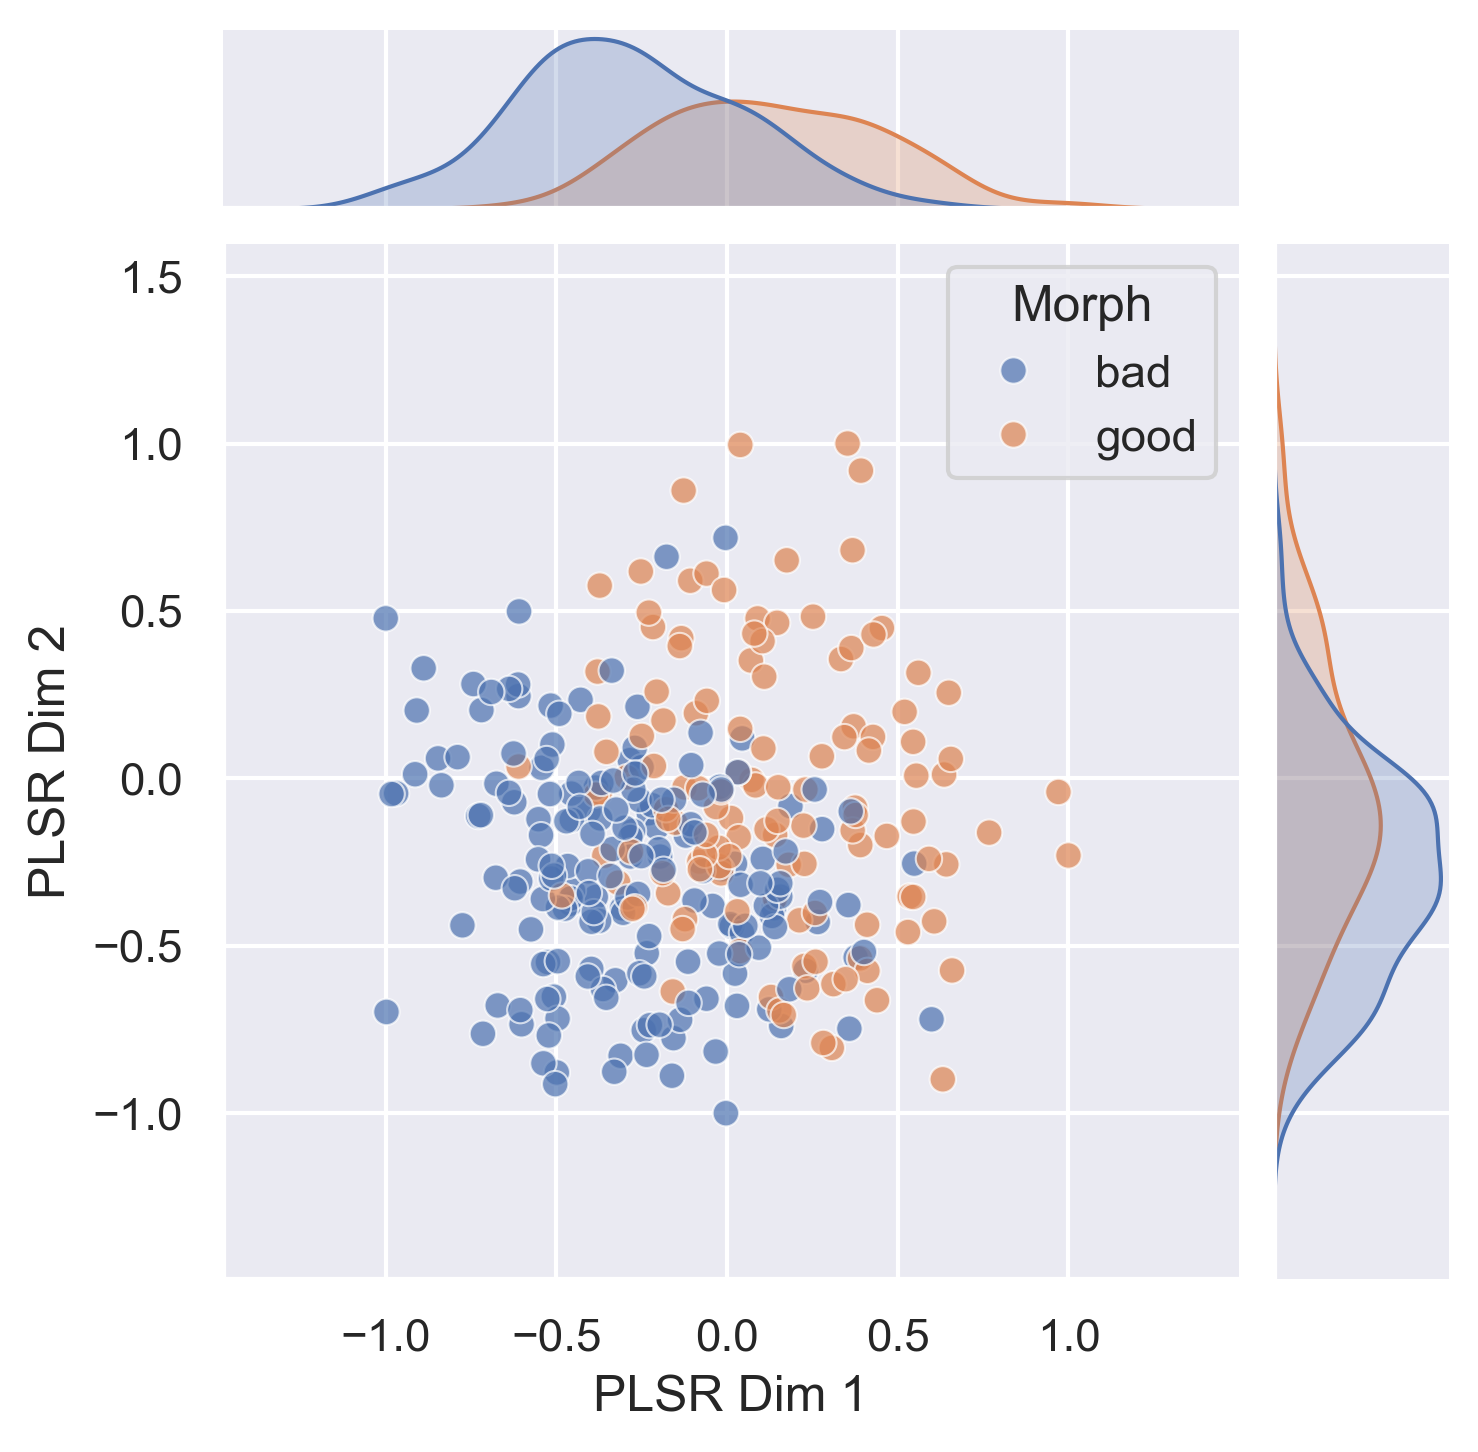

In [4]:
sns.set()

df_components = pd.DataFrame(
    {
        "Morph":dat_morph["Morph"].to_numpy(),
        "good":Y.to_numpy().astype(bool),
        "PLSR Dim 1":std_scores_dim1,
        "PLSR Dim 2":std_scores_dim2,
    }
)

sns.jointplot(df_components,x="PLSR Dim 1",y="PLSR Dim 2",hue="Morph", **{"alpha":0.7,"s":40},height=5,hue_order=["bad","good"])
plt.show()

In [5]:
# randomised labels
random_X = np.array(X)[np.random.choice(len(X), size = len(X),replace = False)]

# fit randomised plsr
my_plsr_random = PLSRegression(n_components=2, scale=False)
my_plsr_random.fit(StandardScaler().fit_transform(random_X), Y)

# extract scores (one score per individual per component)
scores_df_random = pd.DataFrame(my_plsr_random.x_scores_)

# standardize scores between -1 and 1 so they fit on the plot
std_random_scores_dim1 = 2 * ( (scores_df_random[0] - min(scores_df_random[0])) / (max(scores_df_random[0]) - min(scores_df_random[0])) ) -1
std_random_scores_dim2 = 2 * ( (scores_df_random[1] - min(scores_df_random[1])) / (max(scores_df_random[1]) - min(scores_df_random[1])) ) -1

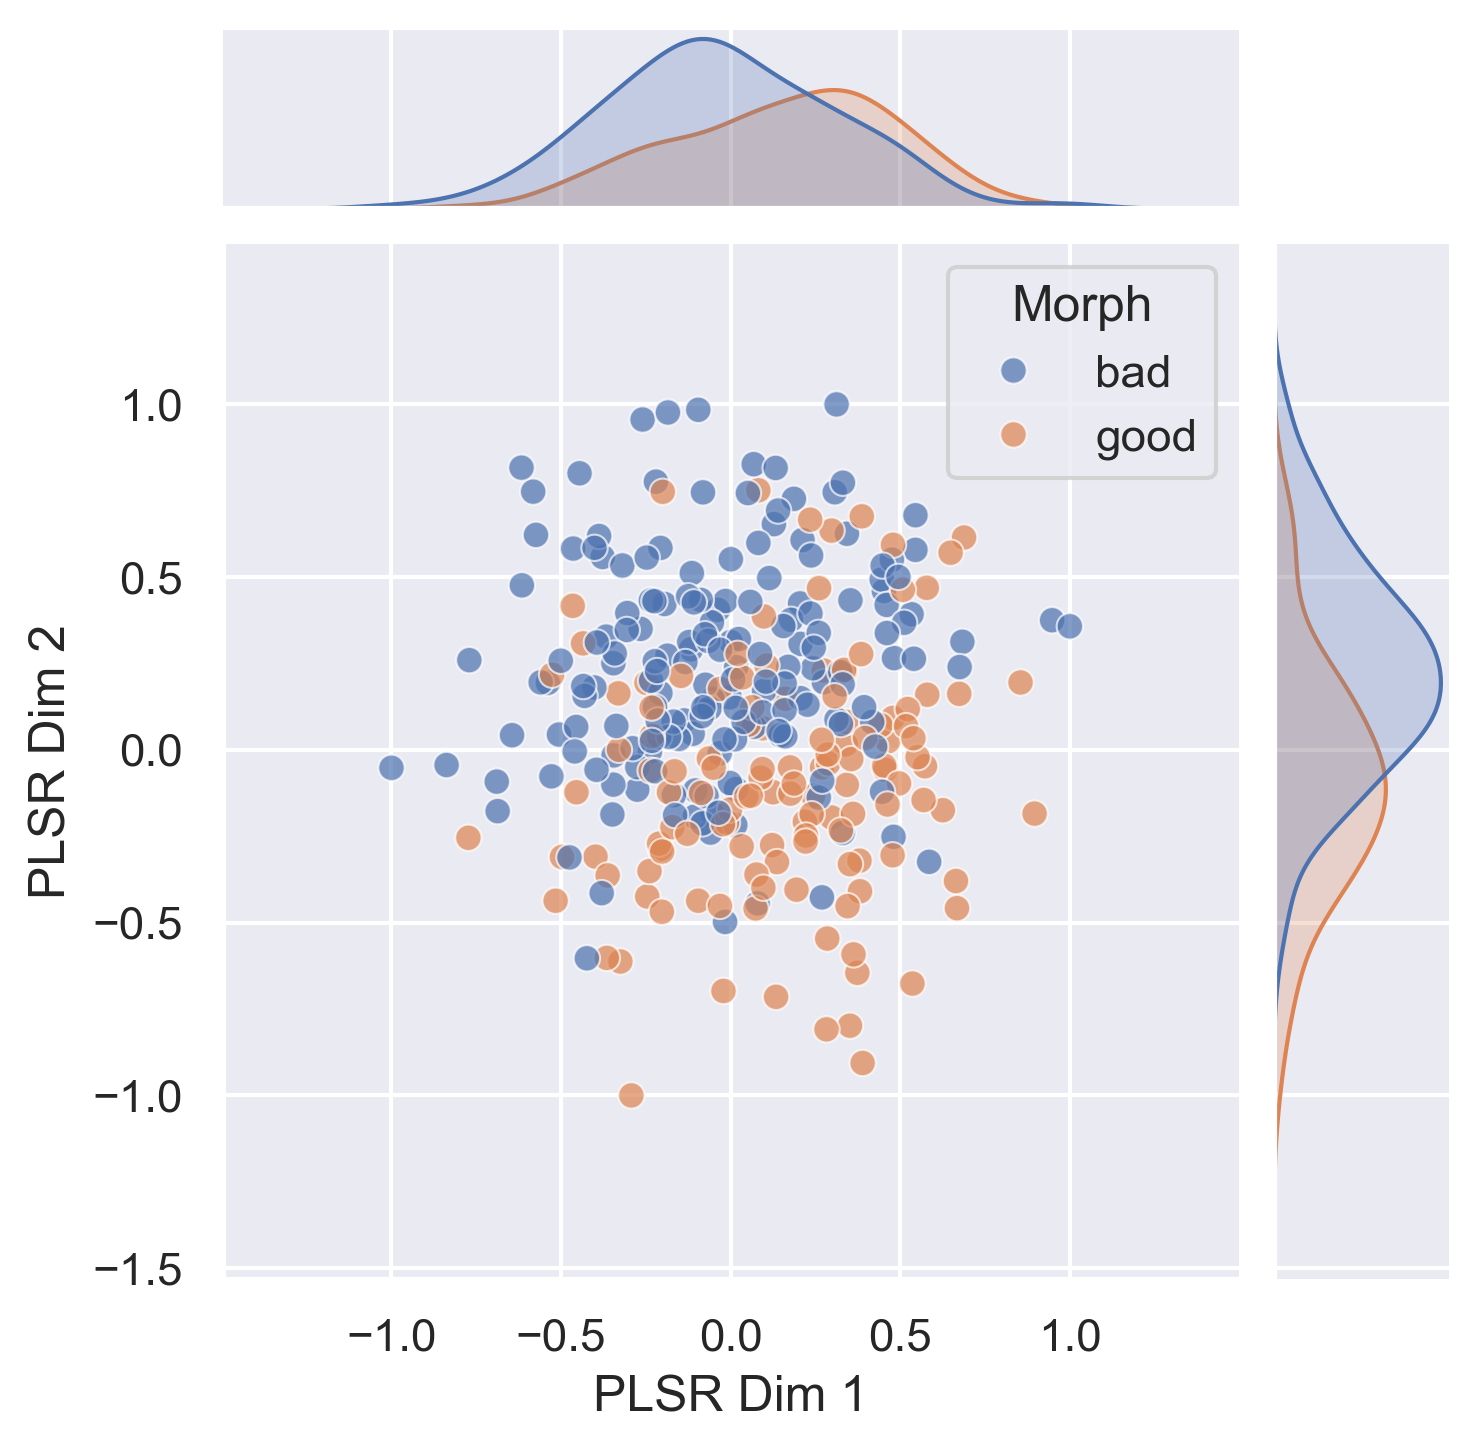

In [6]:
df_components = pd.DataFrame(
    {
        "Morph":dat_morph["Morph"].to_numpy(),
        "good":Y.to_numpy().astype(bool),
        "PLSR Dim 1":std_random_scores_dim1,
        "PLSR Dim 2":std_random_scores_dim2,
    }
)

sns.jointplot(df_components,x="PLSR Dim 1",y="PLSR Dim 2",hue="Morph", **{"alpha":0.7,"s":40},height=5,hue_order=["bad","good"])
#plt.savefig(f"{out_fig_2}/PLSR Morph components.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
df_components[df_components["good"] == True]["PLSR Dim 1"].mean() > df_components[df_components["good"] == False]["PLSR Dim 1"].mean()

True

In [8]:
# Repeating PLSR multiple times while just randomising the order of samples

np.random.seed(42)

n_to_leave_out = int(0.2*len(X))
print(n_to_leave_out)

normal_plsr_loadings = []
normal_plsr_scores = []
normal_indices = []
normal_labels = []

for i in range(100):
    random_indices = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    random_indices_2 = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    
    normal_indices.append(random_indices)
    
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(StandardScaler().fit_transform(np.array(X)[random_indices]), np.array(Y)[random_indices])
    
    normal_labels.append(np.array(Y)[random_indices])
    # extract scores (one score per individual per component)
    scores_df = pd.DataFrame(my_plsr.x_scores_,columns=["PLSR_Dim_1","PLSR_Dim_2"])
    scores_df["original_indices"] = random_indices
    scores_df["good"] = np.array(Y)[random_indices]
    normal_plsr_scores.append(scores_df.set_index("original_indices"))
    
    # extract_loadings
    loadings_df = pd.DataFrame(my_plsr.x_loadings_,index=X.columns,columns=["PLSR Dim 1","PLSR Dim 2"])
    normal_plsr_loadings.append(loadings_df)

62


In [9]:
pd.concat([df[["PLSR_Dim_1","good"]] for df in normal_plsr_scores],axis=1)

,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,...,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good
original_indices,,,,,,,,,,,,,,,,,,,,,
290,7.043373,True,9.394367,True,8.150959,True,NaN,NaN,8.893038,True,...,NaN,NaN,7.509437,True,NaN,NaN,6.885269,True,8.024977,True
9,8.135880,True,NaN,NaN,7.773310,True,NaN,NaN,NaN,NaN,...,7.905391,True,8.455326,True,8.260267,True,8.371458,True,8.085907,True
57,6.984693,True,NaN,NaN,6.722271,True,6.923254,True,6.626797,True,...,6.550519,True,6.735804,True,NaN,NaN,NaN,NaN,7.156017,True
60,-2.762962,False,-2.635696,False,-3.059067,False,-2.976501,False,-2.983955,False,...,-3.025912,False,NaN,NaN,-3.058548,False,-3.559360,False,-3.132007,False
25,-3.875979,True,-4.910142,True,-4.892284,True,-5.206292,True,-3.828304,True,...,NaN,NaN,NaN,NaN,-5.062197,True,-4.899759,True,-3.913527,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,NaN,NaN,NaN,NaN,-2.378488,False,-1.678721,False,-2.085052,False,...,-2.032081,False,-1.800703,False,NaN,NaN,-2.604912,False,-2.205554,False
241,NaN,NaN,NaN,NaN,4.136961,False,4.814272,False,4.452467,False,...,NaN,NaN,4.877976,False,4.313598,False,NaN,NaN,4.144232,False
53,NaN,NaN,NaN,NaN,-11.816079,False,-11.682946,False,-12.094509,False,...,-12.601339,False,-12.125344,False,-12.474055,False,-13.446349,False,-12.106157,False


In [10]:
# Repeating PLSR multiple times while just randomising the labels

np.random.seed(42)

random_plsr_loadings = []
random_plsr_scores = []
indices_random_1 = []
indices_random_2 = []
for i in range(100):
    random_indices = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    random_indices_2 = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    
    indices_random_1.append(random_indices)
    indices_random_2.append(random_indices_2)
    
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(StandardScaler().fit_transform(np.array(X)[random_indices]), np.array(Y)[random_indices_2])
    
    # extract scores (one score per individual per component)
    scores_df = pd.DataFrame(my_plsr.x_scores_,columns=["PLSR_Dim_1","PLSR_Dim_2"])
    scores_df["original_indices"] = random_indices
    scores_df["randomised good"] = np.array(Y)[random_indices_2]
    random_plsr_scores.append(scores_df.set_index("original_indices"))
    
    # extract_loadings
    loadings_df = pd.DataFrame(my_plsr.x_loadings_,index=X.columns,columns=["PLSR Dim 1","PLSR Dim 2"])
    random_plsr_loadings.append(loadings_df)

In [11]:
pd.concat([df[["PLSR_Dim_1","randomised good"]] for df in random_plsr_scores],axis=1)

,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,...,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good
original_indices,,,,,,,,,,,,,,,,,,,,,
290,1.537673,True,-1.238716,False,5.232800,False,NaN,NaN,9.680726,True,...,NaN,NaN,-2.732530,False,NaN,NaN,4.805078,True,-0.315402,True
9,3.453078,False,NaN,NaN,0.171021,True,NaN,NaN,NaN,NaN,...,2.190153,False,-4.055120,True,-2.697567,False,0.717264,False,4.482858,True
57,1.914503,False,NaN,NaN,0.906858,True,5.444010,True,0.407591,False,...,-0.153276,True,-3.760335,True,NaN,NaN,NaN,NaN,-4.701658,False
60,-0.697247,False,-2.627843,False,-5.311245,True,-0.596303,False,0.229603,True,...,1.508525,False,NaN,NaN,1.705979,True,-0.914194,True,-0.020364,True
25,-1.942847,False,-4.050795,False,-7.726870,True,-3.089001,False,-1.183182,False,...,NaN,NaN,NaN,NaN,-2.442482,False,-4.599892,True,0.235081,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,NaN,NaN,NaN,NaN,-0.052424,False,-0.263028,False,-1.325810,False,...,2.771704,True,2.541154,True,NaN,NaN,3.569626,False,1.425498,False
241,NaN,NaN,NaN,NaN,2.069540,False,1.537004,True,0.328031,False,...,NaN,NaN,-0.386729,True,0.633727,False,NaN,NaN,3.060175,True
53,NaN,NaN,NaN,NaN,-6.972712,True,-6.167472,False,4.692388,False,...,4.115839,False,6.149539,False,10.810899,True,9.981371,False,2.443503,False


In [12]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

metrics = [davies_bouldin_score,calinski_harabasz_score,silhouette_score]

score_dataframes = []

for name,label_name,plsr_scores in zip(["Normal","Random"],["good","randomised good"],[normal_plsr_scores,random_plsr_scores]):
    
    
    separation_index = pd.DataFrame()
    separation_index["Data"] = [name for i in range(len(plsr_scores))]
    for metric in metrics:
        scores = []
        for df in plsr_scores:
            feats = df[["PLSR_Dim_1","PLSR_Dim_2"]]
            labels = df[label_name]
            score = metric(feats,labels)
            #print(score)
            scores.append(score)
        separation_index[metric.__name__] = scores
        
    score_dataframes.append(separation_index)
    
all_scores = pd.concat(score_dataframes,axis=0,ignore_index=True)
all_scores

,Data,davies_bouldin_score,calinski_harabasz_score,silhouette_score
0,Normal,1.605656,74.153025,0.181694
1,Normal,1.600831,75.490033,0.185162
2,Normal,1.527825,83.487889,0.197628
3,Normal,1.471561,88.723092,0.209078
4,Normal,1.557280,79.269877,0.192815
...,...,...,...,...
195,Random,1.930993,51.265428,0.144427
196,Random,2.278441,37.265754,0.114726
197,Random,2.272251,35.359642,0.093868
198,Random,2.366221,34.132510,0.092888


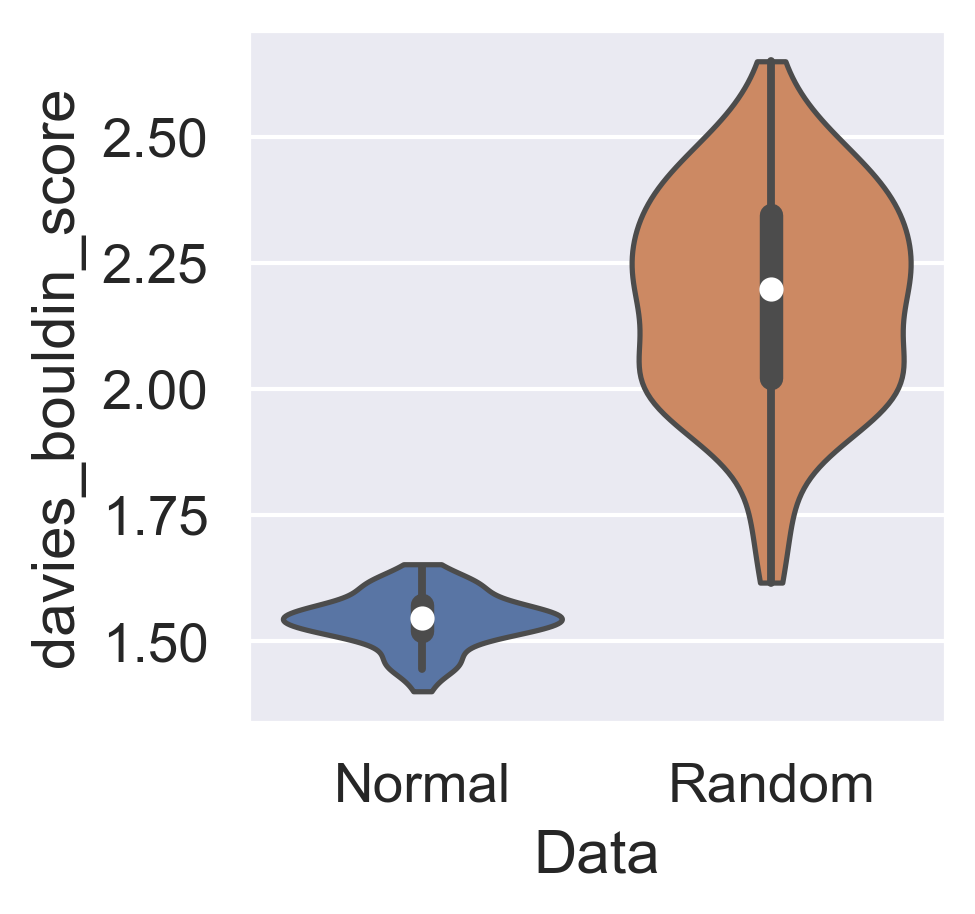

In [13]:
import os

out_revisions = r"D:\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation\Plots\Revisions"
if not os.path.isdir(out_revisions):
    os.mkdir(out_revisions)

sns.set(font_scale=1.2)
    
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(all_scores,x="Data",y="davies_bouldin_score",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
plt.savefig(f"{out_revisions}/PLSR Morph Davies Bouldin Score 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

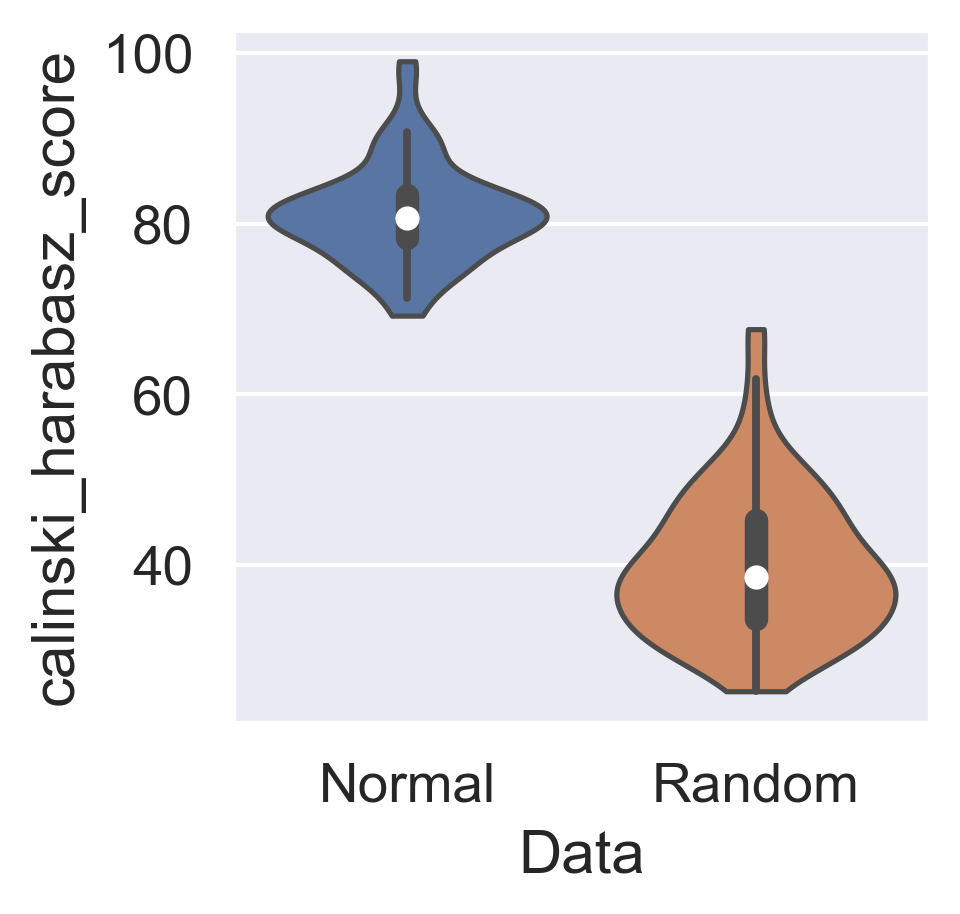

In [14]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(all_scores,x="Data",y="calinski_harabasz_score",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
plt.savefig(f"{out_revisions}/PLSR Morph Calinski Harabasz Score 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

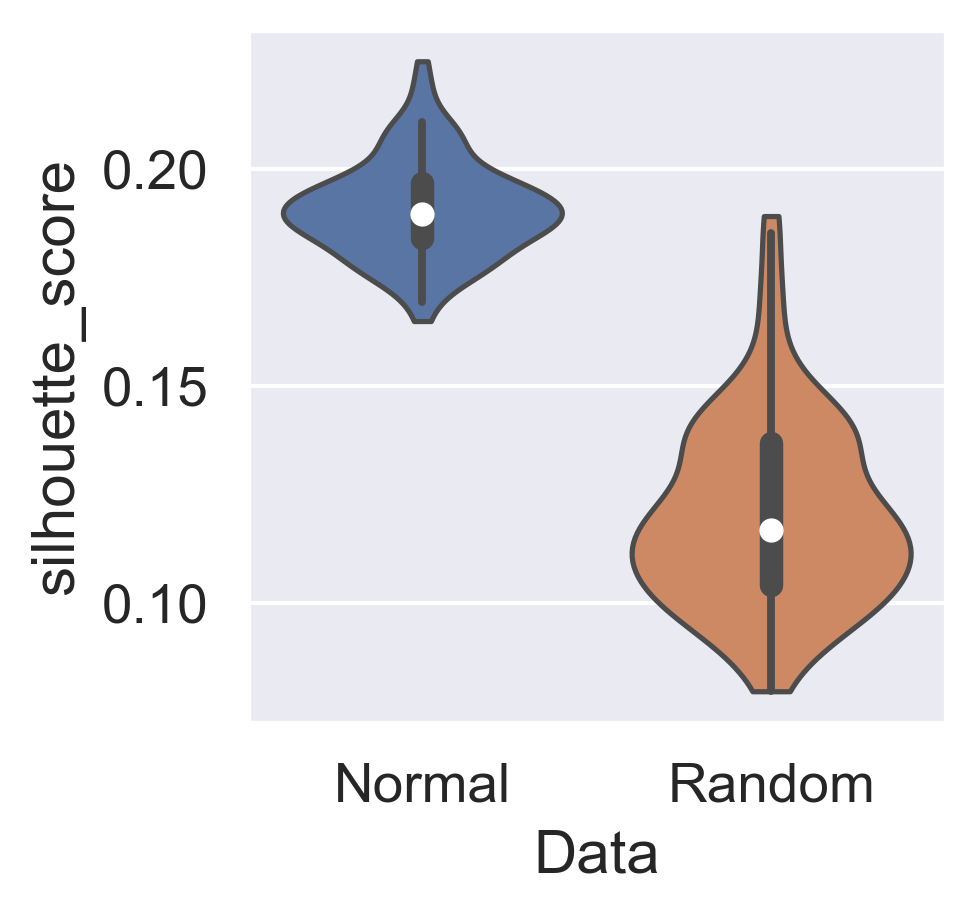

In [15]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(all_scores,x="Data",y="silhouette_score",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
plt.savefig(f"{out_revisions}/PLSR Morph Silhouette Score 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

In [16]:
score_ranks = {metric.__name__:all_scores[metric.__name__].rank(ascending=bool(flag)).to_numpy() for metric, flag in zip(metrics, [0,1,1])}
score_ranks = pd.DataFrame(score_ranks)
score_ranks["Data"] = all_scores["Data"]
score_ranks["Avg Rank"] = np.mean(score_ranks[["davies_bouldin_score","calinski_harabasz_score","silhouette_score"]].to_numpy(),axis=1)
score_ranks

,davies_bouldin_score,calinski_harabasz_score,silhouette_score,Data,Avg Rank
0,114.0,108.0,120.0,Normal,114.000000
1,118.0,118.0,127.0,Normal,121.000000
2,168.0,177.0,182.0,Normal,175.666667
3,188.0,189.0,193.0,Normal,190.000000
4,137.0,135.0,163.0,Normal,145.000000
...,...,...,...,...,...
195,91.0,91.0,91.0,Random,91.000000
196,35.0,44.0,48.0,Random,42.333333
197,36.0,35.0,8.0,Random,26.333333
198,20.0,28.0,5.0,Random,17.666667


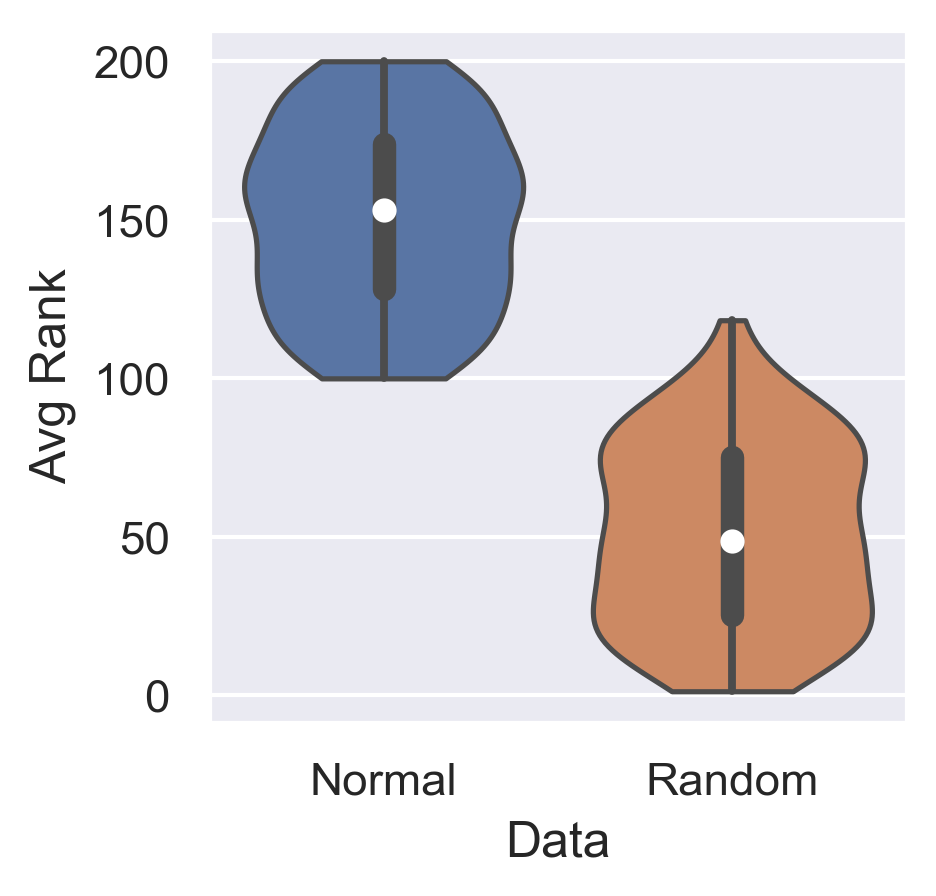

In [17]:
sns.set()

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(score_ranks,x="Data",y="Avg Rank",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
#sns.stripplot(score_ranks,x="Data",y="Avg Rank",ax=ax,palette="tab10",alpha=0.7,edgecolor = "white", linewidths = 2)
plt.savefig(f"{out_revisions}/PLSR Morph avg separation rank 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

<Axes: xlabel='Data', ylabel='Avg Rank'>

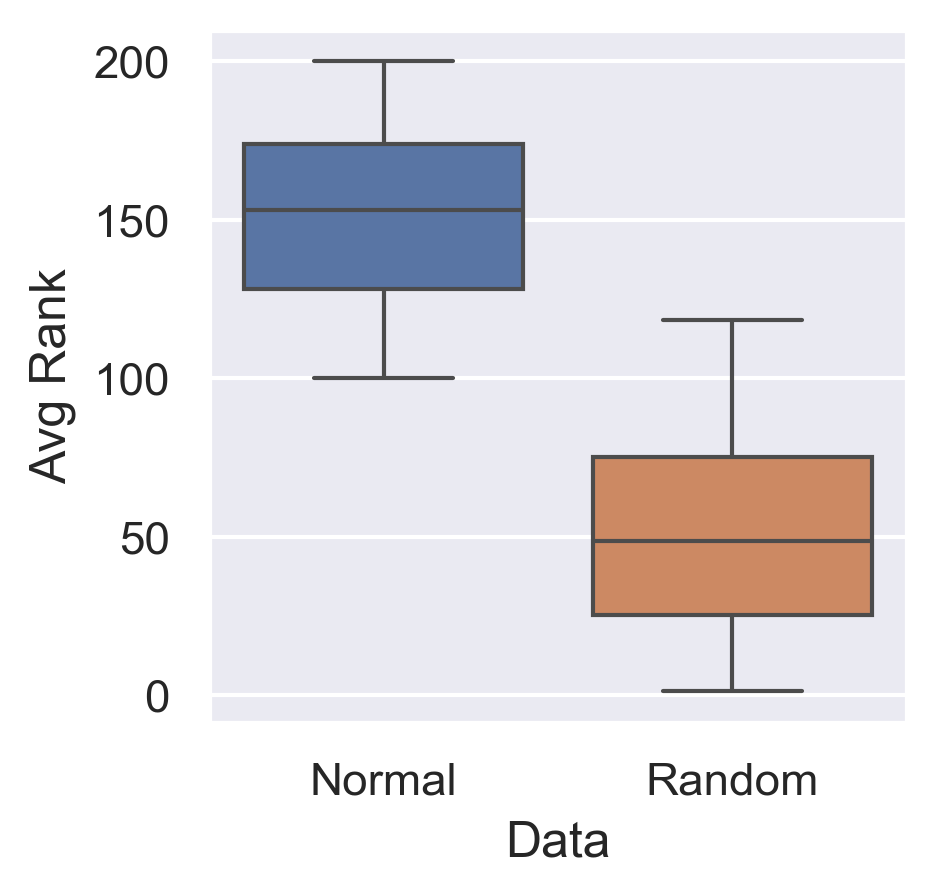

In [18]:
sns.set()

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.boxplot(score_ranks,x="Data",y="Avg Rank",ax=ax, hue="Data")
#sns.stripplot(score_ranks,x="Data",y="Avg Rank",ax=ax,palette="tab10",alpha=0.7,edgecolor = "white", linewidths = 2)
#plt.savefig(f"{out_revisions}/PLSR Morph avg separation rank 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

In [19]:
kfold_split = model_selection.StratifiedKFold(n_splits=5)
kfold_split.get_n_splits(X,Y)

5

In [22]:
from sklearn import metrics

all_confusion_matrices = []
all_test_y_pred_y = []
all_pred_y_nothresh = []
for i, (train_index, test_index) in enumerate(kfold_split.split(X,Y)):
    train_X, test_X, train_Y, test_Y = X.to_numpy()[train_index],X.to_numpy()[test_index],Y.to_numpy()[train_index],Y.to_numpy()[test_index]
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(np.array(train_X), np.array(train_Y))

    test_pred = (my_plsr.predict(np.array(test_X)) > 0.5)[:,0]
    matrix = metrics.confusion_matrix(test_Y,test_pred,)
    all_confusion_matrices.append(matrix)
    all_test_y_pred_y.append((test_Y,test_pred))
    all_pred_y_nothresh.append(my_plsr.predict(np.array(test_X)))

In [23]:
norm_confusion_matrices = [matrix/np.sum(matrix) for matrix in all_confusion_matrices]

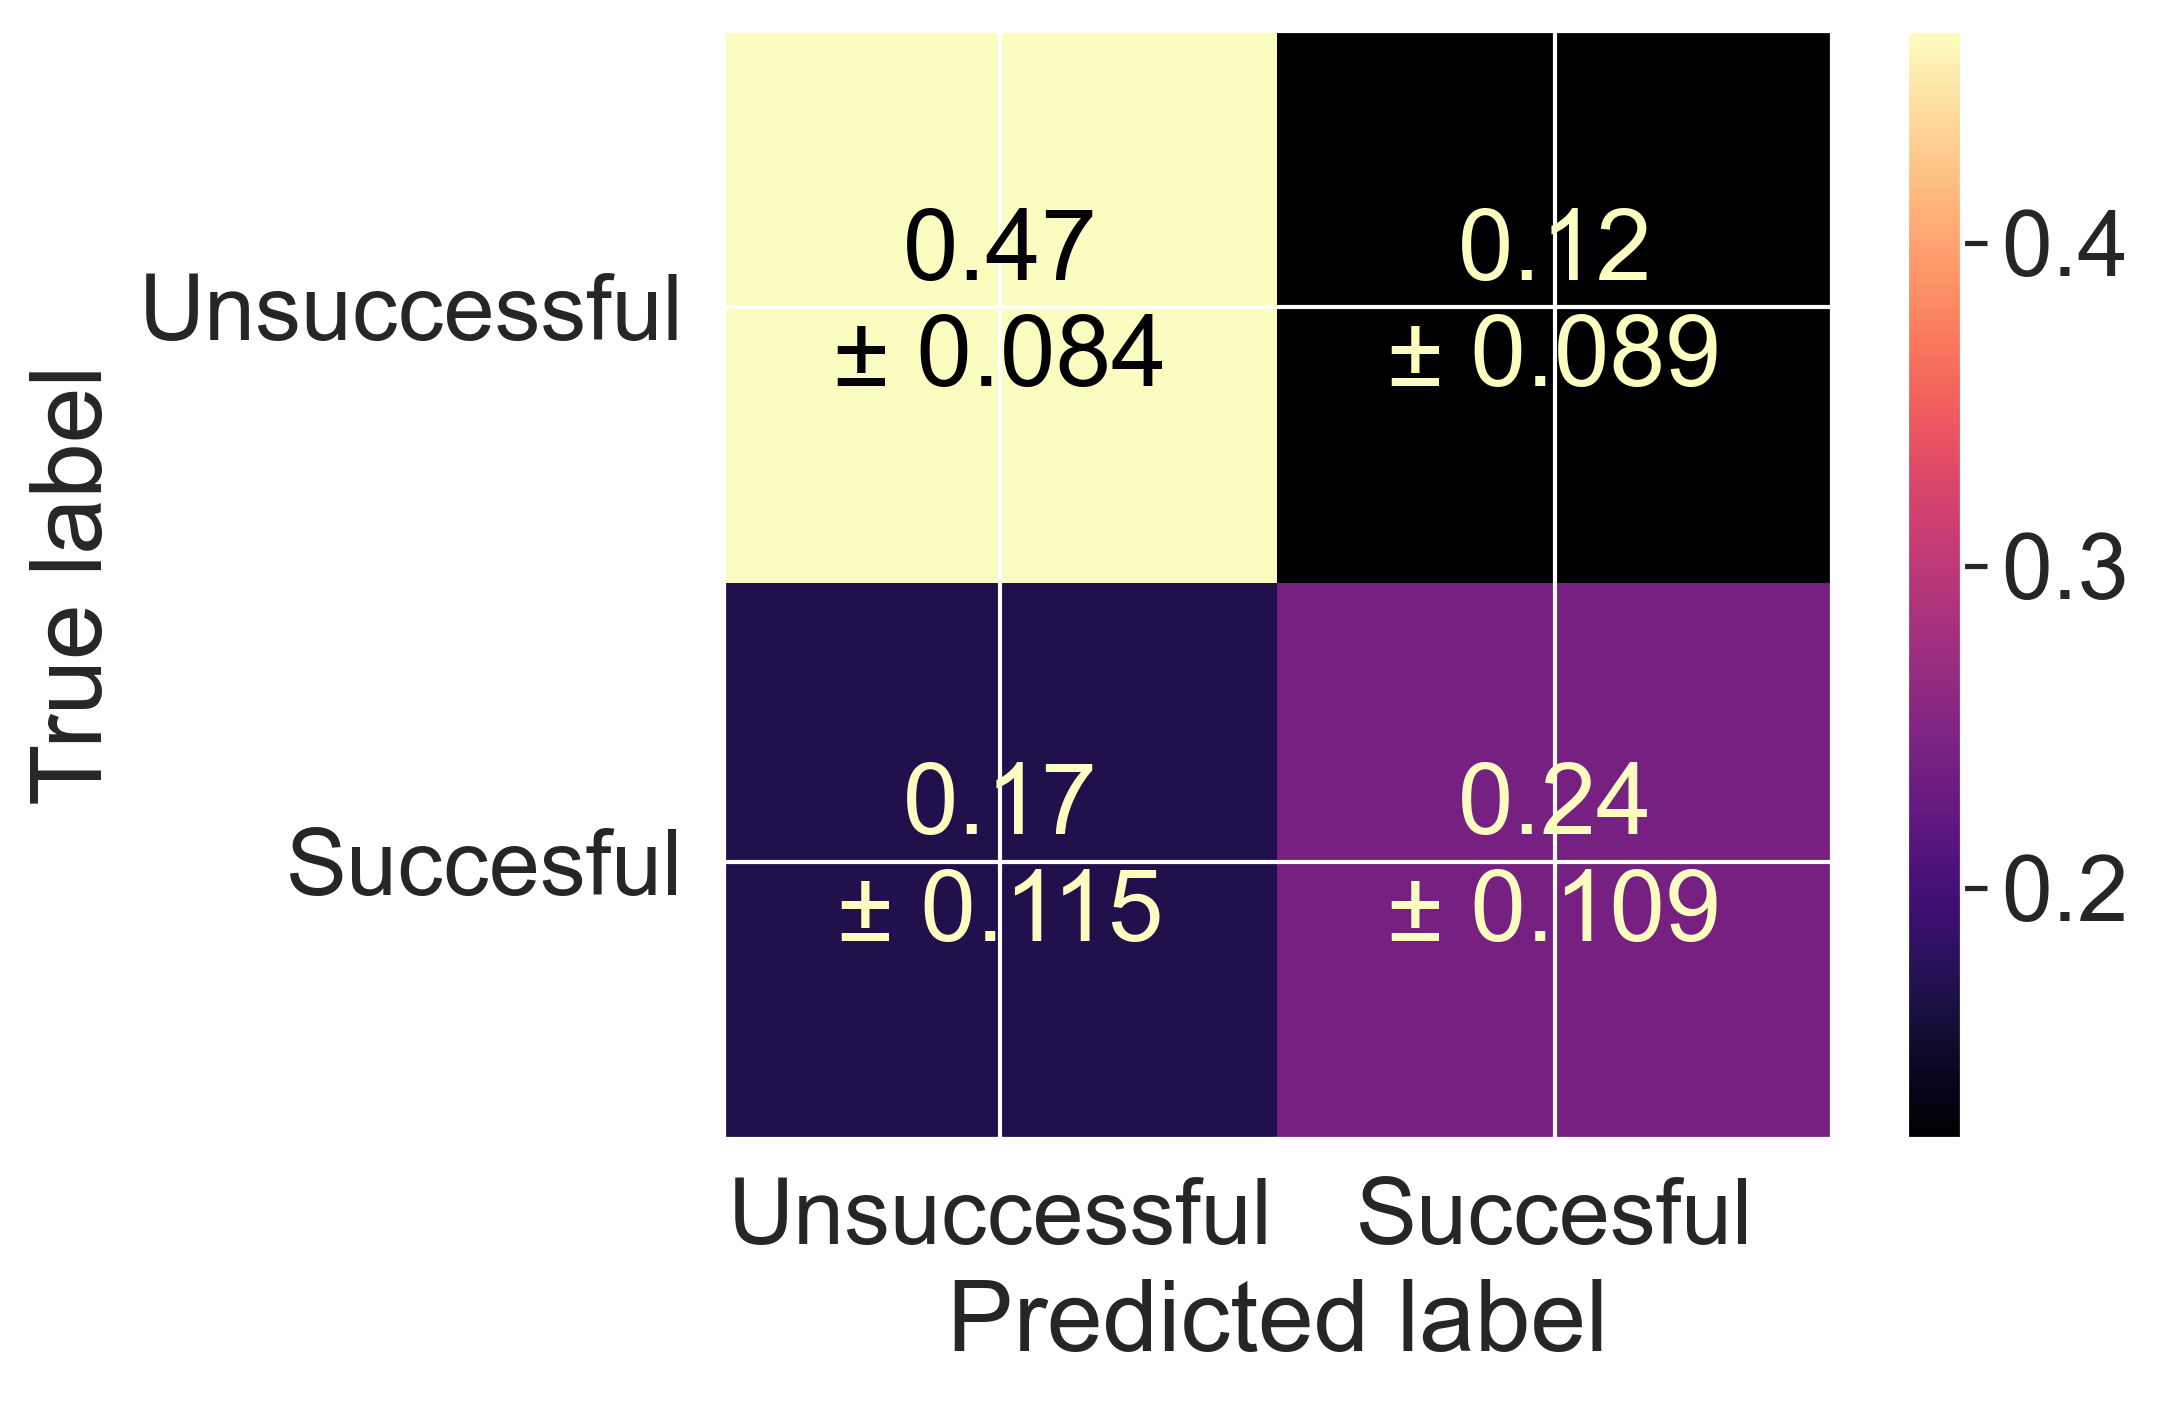

In [24]:
sns.set(font_scale = 2)
disp = metrics.ConfusionMatrixDisplay(np.mean(norm_confusion_matrices,axis=0),display_labels=["Unsuccessful","Succesful"],)
disp.plot(cmap="magma")
new_text_mat = np.zeros_like(disp.text_)

for i,(row_text, row_std) in enumerate(zip(disp.text_,np.std(norm_confusion_matrices,axis=0))):
    for j,(text_object, std_dev) in enumerate(zip(row_text,row_std)):
        new_text = text_object._text +"\n"+u"\u00B1"+" "+ str(np.round(std_dev,decimals=3))
        text_object._text = new_text
        new_text_mat[i,j] = text_object

disp.text_ = new_text_mat
disp.figure_

plt.savefig(f"{out_revisions}/PLSR Morph Predictions COnfusion Matrix 5 Fold Cross Validation.pdf", format="pdf", bbox_inches="tight")

In [25]:
balanced_accuracies_normal = [metrics.balanced_accuracy_score(true,pred) for true, pred in all_test_y_pred_y]
balanced_accuracies_normal

[0.6746361746361746,
 0.5491452991452992,
 0.6944444444444444,
 0.8254054054054054,
 0.7167567567567568]

In [36]:
roc_auc_normal = [metrics.roc_auc_score(true,pred) for (true,_),pred in zip(all_test_y_pred_y,all_pred_y_nothresh)]
roc_auc_normal

[0.760914760914761,
 0.7083333333333334,
 0.7702991452991453,
 0.9124324324324324,
 0.8464864864864864]

In [37]:
np.random.seed(42)

random_indices = np.random.choice(len(X),size = len(X), replace=False)

all_confusion_matrices_random = []
all_test_y_pred_y_random = []
all_pred_y_nothresh_random = []
X_np = X.to_numpy()
Y_np = Y.to_numpy()[random_indices]


for i, (train_index, test_index) in enumerate(kfold_split.split(X_np,Y_np)):
    train_X, test_X, train_Y, test_Y = X_np[train_index],X_np[test_index],Y_np[train_index],Y_np[test_index]
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(np.array(train_X), np.array(train_Y))

    test_pred = (my_plsr.predict(np.array(test_X)) > 0.5)[:,0]
    matrix = metrics.confusion_matrix(test_Y,test_pred,)
    all_confusion_matrices_random.append(matrix)
    all_test_y_pred_y_random.append((test_Y,test_pred))
    all_pred_y_nothresh_random.append(my_plsr.predict(np.array(test_X)))

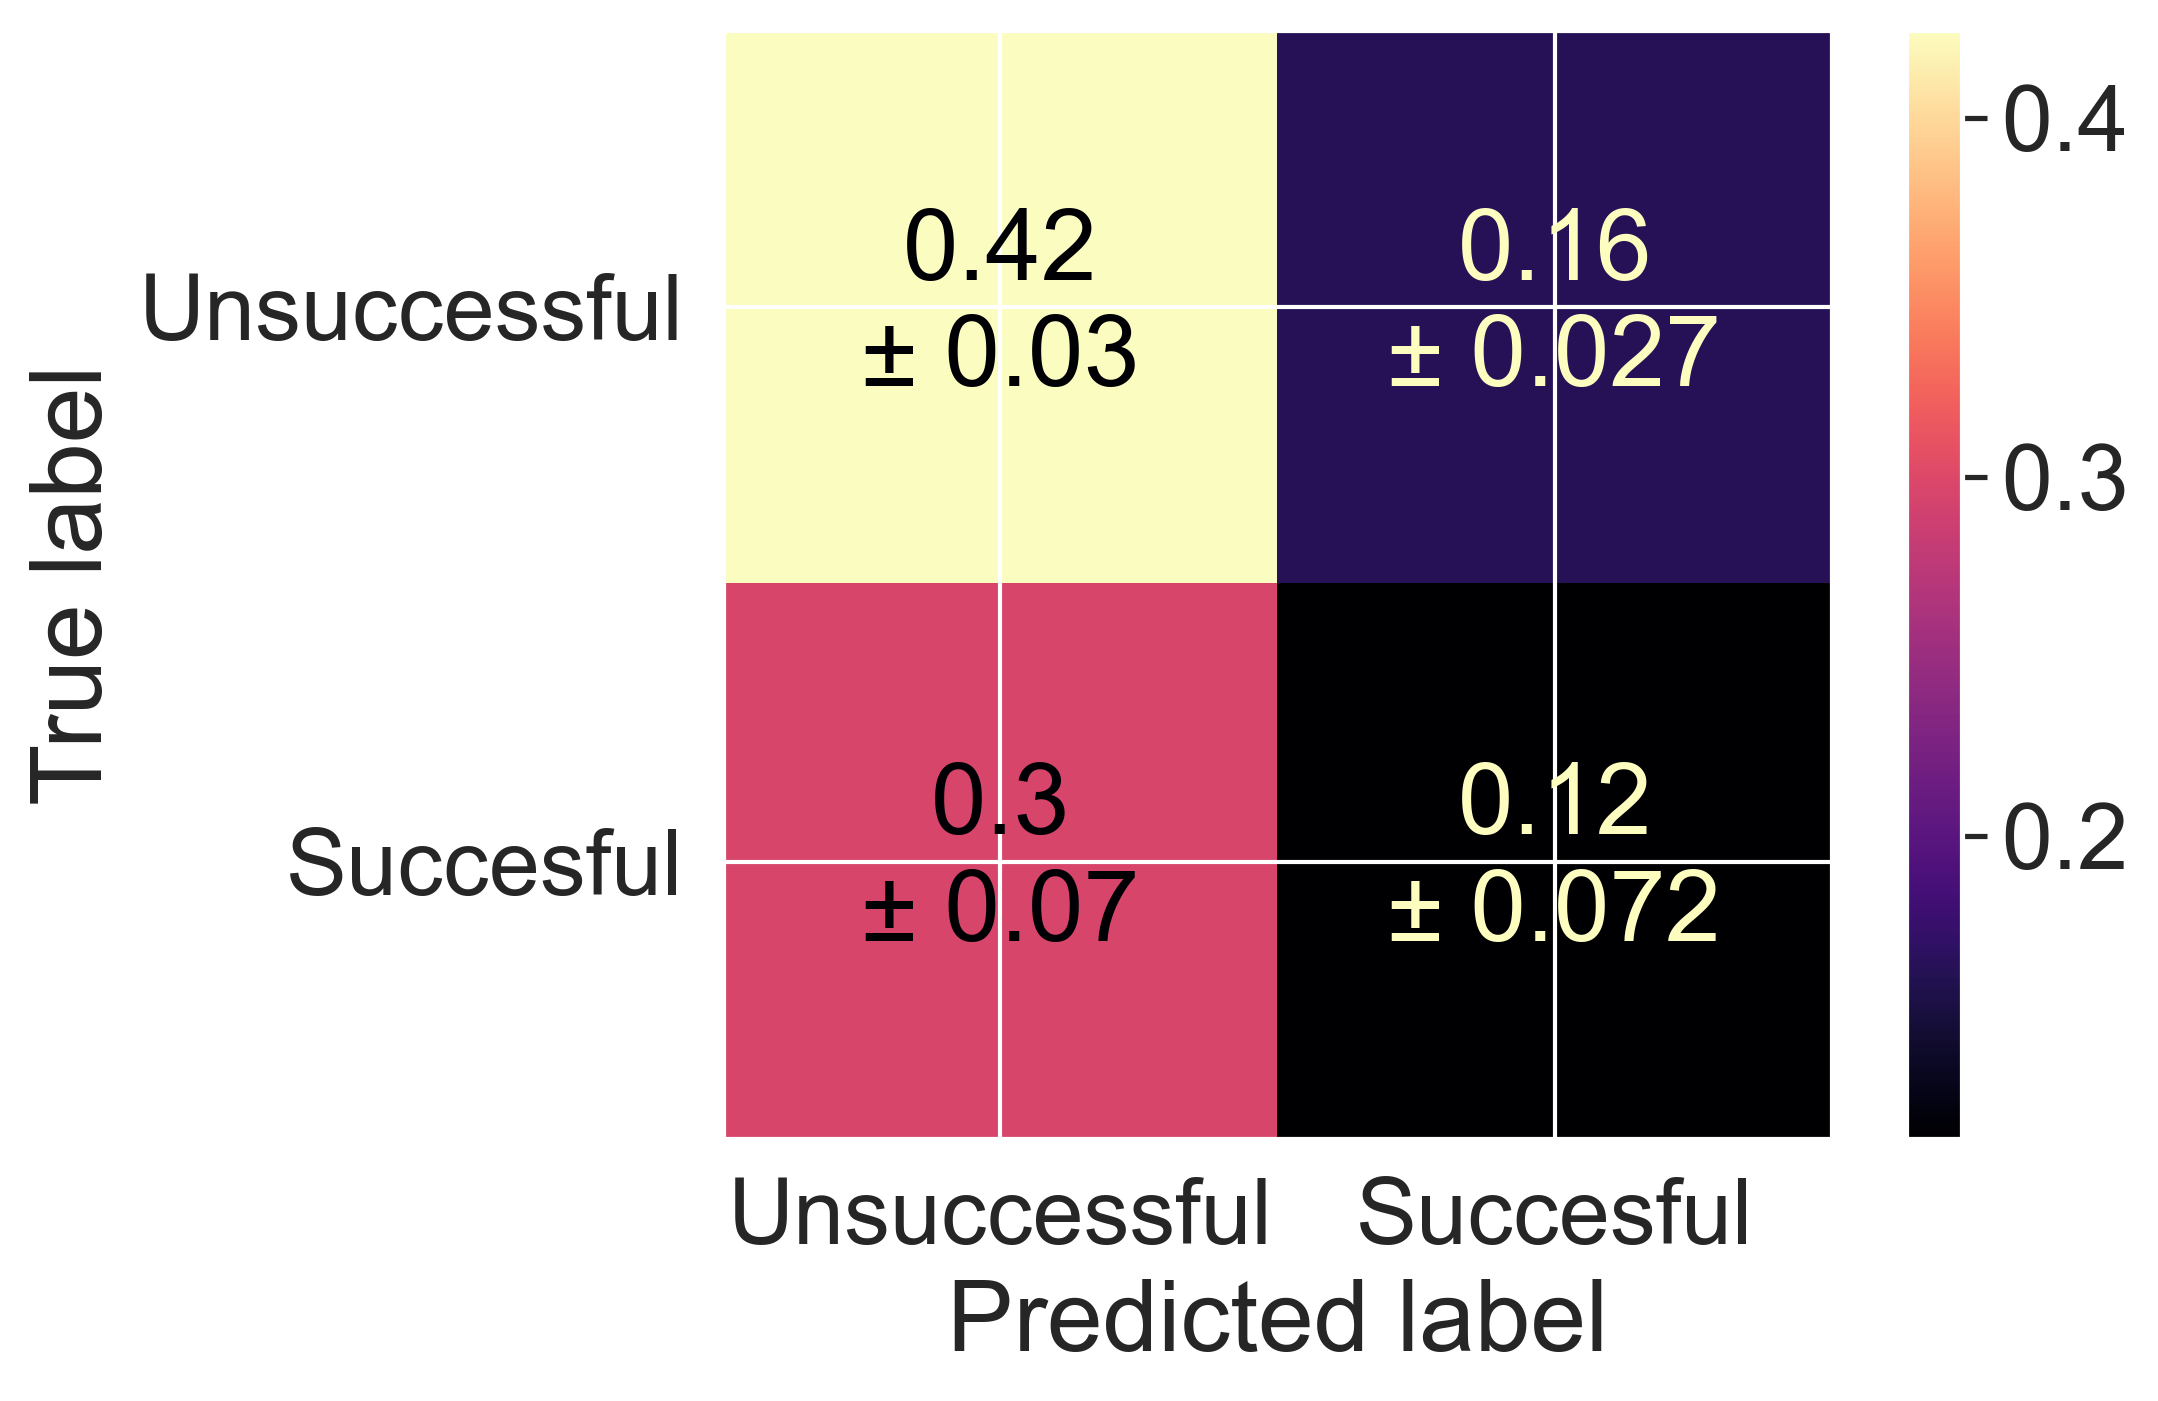

In [38]:
norm_confusion_matrices_random = [matrix/np.sum(matrix) for matrix in all_confusion_matrices_random]
sns.set(font_scale = 2)
disp_random = metrics.ConfusionMatrixDisplay(np.mean(norm_confusion_matrices_random,axis=0),display_labels=["Unsuccessful","Succesful"])
disp_random.plot(cmap="magma")
new_text_mat = np.zeros_like(disp.text_)

for i,(row_text, row_std) in enumerate(zip(disp_random.text_,np.std(norm_confusion_matrices_random,axis=0))):
    for j,(text_object, std_dev) in enumerate(zip(row_text,row_std)):
        new_text = text_object._text +"\n"+u"\u00B1"+" "+ str(np.round(std_dev,decimals=3))
        text_object._text = new_text
        new_text_mat[i,j] = text_object

disp_random.text_ = new_text_mat
disp_random.figure_

plt.savefig(f"{out_revisions}/PLSR Morph Random Predictions Confusion Matrix 5 Fold Cross Validation.pdf", format="pdf", bbox_inches="tight")

In [39]:
balanced_accuracies_random = [metrics.balanced_accuracy_score(true,pred) for true, pred in all_test_y_pred_y_random]
balanced_accuracies_random

[0.4589397089397089,
 0.41346153846153844,
 0.6356837606837606,
 0.4718918918918919,
 0.5248648648648648]

In [40]:
roc_auc_random = [metrics.roc_auc_score(true,pred) for (true,_),pred in zip(all_test_y_pred_y_random,all_pred_y_nothresh_random)]
roc_auc_random

[0.45322245322245325,
 0.485042735042735,
 0.6324786324786325,
 0.5145945945945946,
 0.4972972972972972]

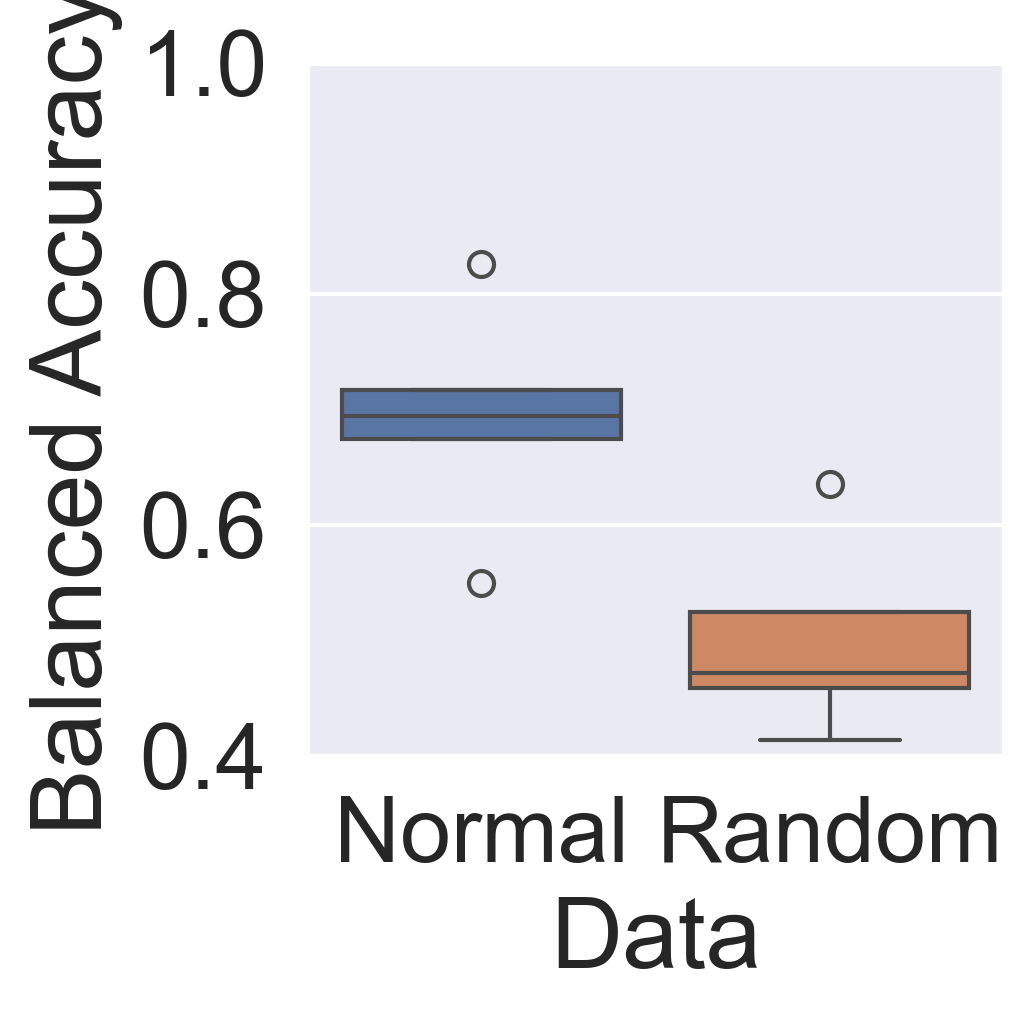

In [41]:
balanced_accuracies_df = pd.DataFrame(
    {
        "Balanced Accuracy":balanced_accuracies_normal+balanced_accuracies_random,
        "Data":["Normal" for i in range(5)] + ["Random" for i in range(5)]
    }
)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.boxplot(balanced_accuracies_df,x="Data",y="Balanced Accuracy",hue="Data",ax=ax)
ax.set_ylim([0.4,1])
plt.savefig(f"{out_revisions}/PLSR Morph PLSR 5fold CV - balanced accuracy.pdf", format="pdf", bbox_inches="tight")

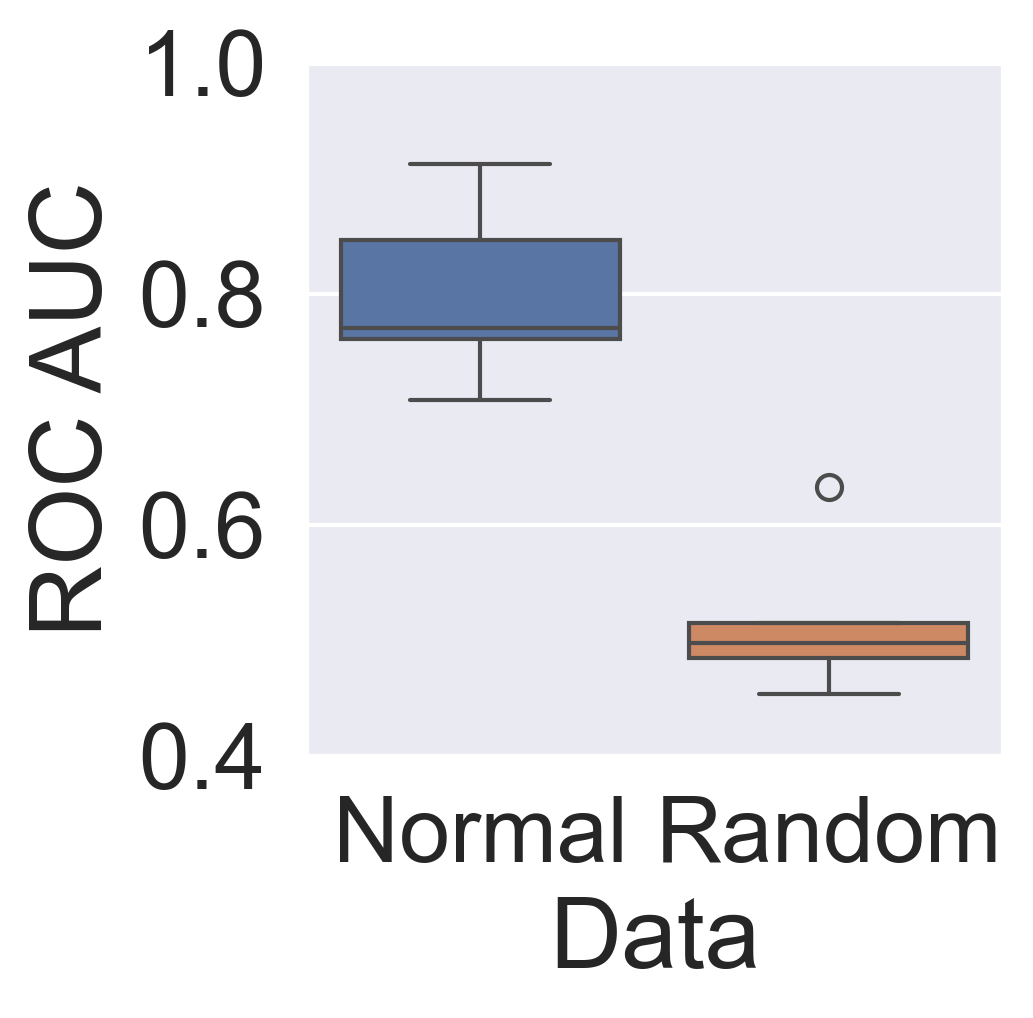

In [42]:
roc_auc_df = pd.DataFrame(
    {
        "ROC AUC":roc_auc_normal+roc_auc_random,
        "Data":["Normal" for i in range(5)] + ["Random" for i in range(5)]
    }
)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.boxplot(roc_auc_df,x="Data",y="ROC AUC",ax=ax,hue="Data")
ax.set_ylim([0.4,1])
plt.savefig(f"{out_revisions}/PLSR Morph PLSR 5fold CV - ROC AUC.pdf", format="pdf", bbox_inches="tight")